<a href="https://colab.research.google.com/github/google/jax-md/blob/main/notebooks/tutorial/Chapter_1_Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Import & Util

import jax.numpy as np
from jax import device_put
from jax import config
# TODO: Uncomment this and enable warnings when XLA bug is fixed.
import warnings; warnings.simplefilter('ignore')
config.update('jax_enable_x64', True)
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import brainunit as u

import warnings
warnings.simplefilter("ignore")

sns.set_style(style='white')
background_color = [56 / 256] * 3
def plot(x, y, *args):
  plt.plot(x, y, *args, linewidth=3)
  plt.gca().set_facecolor([1, 1, 1])
def draw(R, **kwargs):
  if 'c' not in kwargs:
    kwargs['color'] = [1, 1, 0.9]
  ax = plt.axes(xlim=(0, float(jnp.max(R[:, 0]))), 
                ylim=(0, float(jnp.max(R[:, 1]))))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax.set_facecolor(background_color)
  plt.scatter(R[:, 0], R[:, 1],  marker='o', s=1024, **kwargs)
  plt.gcf().patch.set_facecolor(background_color)
  plt.gcf().set_size_inches(6, 6)
  plt.tight_layout()
def draw_big(R, **kwargs):
  if 'c' not in kwargs:
    kwargs['color'] = [1, 1, 0.9]
  fig = plt.figure(dpi=128)
  ax = plt.axes(xlim=(0, float(jnp.max(R[:, 0]))),
                ylim=(0, float(jnp.max(R[:, 1]))))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax.set_facecolor(background_color)
  s = plt.scatter(R[:, 0], R[:, 1], marker='o', s=0.5, **kwargs)
  s.set_rasterized(True)
  plt.gcf().patch.set_facecolor(background_color)
  plt.gcf().set_size_inches(10, 10)
  plt.tight_layout()
def draw_displacement(R, dR):
  plt.quiver(R[:, 0], R[:, 1], dR[:, 0], dR[:, 1], color=[1, 0.5, 0.5])

# Progress Bars

from IPython.display import HTML, display
import time

def ProgressIter(iter_fun, iter_len=0):
  if not iter_len:
    iter_len = len(iter_fun)
  out = display(progress(0, iter_len), display_id=True)
  for i, it in enumerate(iter_fun):
    yield it
    out.update(progress(i + 1, iter_len))

def progress(value, max):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 45%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# JAX MD Tutorial ([tutorial.jax-md.org](https://tutorial.jax-md.org))

## Chapter 1: Introduction

### Energy and Automatic Differentiation

$$
u(r) = \begin{cases}\frac13(1 - r)^3 & \text{if $r < 1$} \\ 0 & \text{otherwise} \end{cases}
$$

In [2]:
import jax.numpy as jnp
from jax_md import units as ju

@u.assign_units(r=ju.angstrom, result=ju.eV_unit)
def soft_sphere(r):
  return u.math.where(r < 1, 
                   1/3 * (1 - r) ** 3,
                   0.)

print(soft_sphere(0.5 * ju.angstrom))

0.04166667 * Electric voltage


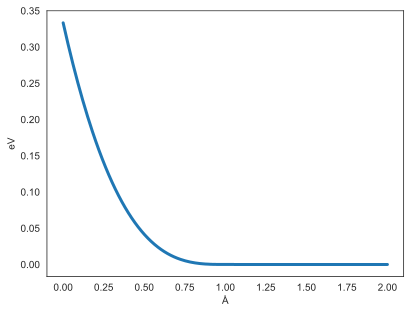

In [3]:
r = u.math.linspace(0 * ju.angstrom, 2. * ju.angstrom, 200)
plot(r, soft_sphere(r))

We can compute its derivative automatically

In [4]:
from brainunit.autograd import grad

du_dr = grad(soft_sphere)

print(du_dr(0.5 * ju.angstrom))

-0.25 * Force


We can vectorize the derivative computation over many radii

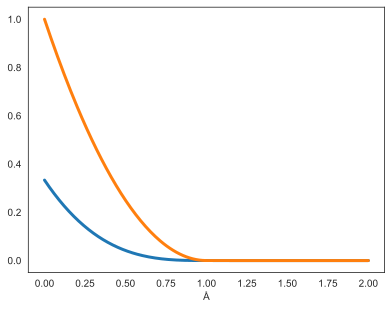

In [5]:
from jax import vmap

du_dr_v = vmap(du_dr)

plot(r, soft_sphere(r).mantissa)
plot(r, -du_dr_v(r).mantissa)

### Randomly Initialize a System

In [6]:
from jax import random

key = random.PRNGKey(1)

particle_count = 128
dim = 2

In [7]:
from jax_md import quantity
from jax_md import units as ju

# number_density = N / V
box_size = quantity.box_size_at_number_density(particle_count = particle_count, 
                                               number_density = 1.2, 
                                               spatial_dimension = dim)

R = random.uniform(key, (particle_count, dim), maxval=box_size.to_decimal(box_size.unit)) * ju.angstrom

In [ ]:
from jax_md.colab_tools import renderer
renderer.render(box_size, renderer.Disk(R), resolution=(512, 512))

### Displacements and Distances


In [9]:
from jax_md import space

displacement, shift = space.periodic(box_size)

print(displacement(R[0], R[1]))

ArrayImpl([-1.75377265, -2.76744061]) * Angstrom


In [10]:
metric = space.metric(displacement)

print(metric(R[0], R[1]))

3.27634644 * Angstrom


Compute distances between pairs of points

In [11]:
v_displacement = space.map_product(displacement)
v_metric = space.map_product(metric)

print(v_metric(R[:3], R[:3]))

ArrayImpl([[0.        , 3.27634644, 1.0188703 ],
           [3.27634644, 0.        , 2.27947659],
           [1.0188703 , 2.27947659, 0.        ]]) * Angstrom


### Total Energy of a System

In [12]:
@u.check_dims(R=ju.angstrom.dim, result=ju.eV.dim)
def energy_fn(R):
  dr = v_metric(R, R)
  return 0.5 * u.math.sum(soft_sphere(dr))

In [13]:
print(energy_fn(R))

28.53733745 * Electric voltage


In [14]:
print(grad(energy_fn)(R).shape)

(128, 2)


### Minimization

In [15]:
from jax_md import minimize

init_fn, apply_fn = minimize.fire_descent(energy_fn, shift)

In [ ]:
state = init_fn(R)

trajectory = []

i = 0
while u.math.max(u.math.abs(state.force)) > 1e-4 * ju.eV / ju.angstrom:
  state = apply_fn(state)
  trajectory += [state.position]
  i += 1
  if i % 100 == 0:
      print(f"i: {i}, force: {u.math.max(u.math.abs(state.force))}")

i: 0, force: 1.1998356223370035 * Force
i: 0, force: 1.199836505598415 * Force
i: 0, force: 1.1998379777019454 * Force
i: 0, force: 1.1998400386494035 * Force
i: 0, force: 1.199842688443352 * Force
i: 0, force: 1.1998459270871416 * Force
i: 0, force: 1.1998501676798605 * Force
i: 0, force: 1.199855651276089 * Force
i: 0, force: 1.19986267703726 * Force
i: 0, force: 1.1998716007144559 * Force
i: 0, force: 1.1998828632589746 * Force
i: 0, force: 1.1998970019909543 * Force
i: 0, force: 1.1999146696116534 * Force
i: 0, force: 1.199936656326475 * Force
i: 0, force: 1.199963930508671 * Force
i: 0, force: 1.199997660678128 * Force
i: 0, force: 1.2000392702516571 * Force
i: 0, force: 1.2000905109943059 * Force
i: 0, force: 1.2001534658530049 * Force
i: 0, force: 1.200230701526741 * Force
i: 0, force: 1.2003217481683146 * Force
i: 0, force: 1.2004222262103936 * Force
i: 0, force: 1.2005321377801046 * Force
i: 0, force: 1.200651485217715 * Force
i: 0, force: 1.200780271077855 * Force
i: 0, force

KeyboardInterrupt: 

In [ ]:
trajectory = jnp.stack(trajectory)

renderer.render(box_size,
                renderer.Disk(trajectory),
                resolution=(512, 512))

In [ ]:
cond_fn = lambda state: jnp.max(jnp.abs(state.force)) > 1e-4

### Faster Simulation Through Compilation

In [ ]:
def min(R):
  init, apply = minimize.fire_descent(energy_fn, shift)

  state = init(R)

  for _ in range(20):
    state = apply(state)

  return energy_fn(state.position)

In [ ]:
%%timeit
min(R).block_until_ready()

In [ ]:
from jax import jit

# Just-In-Time compile to GPU
min = jit(min)

In [ ]:
# The first call incurs a compilation cost
min(R)

In [ ]:
%%timeit
min(R).block_until_ready()

In [ ]:
from jax import lax

@jit
def min(R):
  init_fn, apply_fn = minimize.fire_descent(energy_fn, shift)

  state = init_fn(R)
  # Using a JAX loop reduces compilation cost
  state = lax.while_loop(cond_fun=cond_fn,
                         body_fun=apply_fn,
                         init_val=state)

  return state.position

In [ ]:
R_is = min(R)

In [ ]:
%%timeit
min(R).block_until_ready()

### Computing Ensemble Averages

In [ ]:
from jax_md import simulate
from jax import lax

sim_steps = 10000
steps_per_write = 100
write_steps = sim_steps // steps_per_write

init_fn, step_fn = simulate.nvt_nose_hoover(energy_fn, shift, dt=5e-3, kT=1e-4)

@jit
def sim(key):
  state = init_fn(key, R_is)

  def sim_fn(i, state_positions):
    state, positions = state_positions
    positions = positions.at[i].set(state.position)
    state = lax.fori_loop(0, steps_per_write, lambda _, s: step_fn(s), state)
    return state, positions

  positions = jnp.zeros((write_steps, particle_count, dim))

  state, positions = lax.fori_loop(0, write_steps, sim_fn, (state, positions))
  return positions

In [ ]:
key = random.PRNGKey(0)
positions = sim(key)

In [ ]:
renderer.render(box_size, renderer.Disk(positions))

In [ ]:
v_sim = vmap(sim)

keys = random.split(key, 10)
positions = v_sim(keys)

In [ ]:
v_displacement = vmap(vmap(displacement))
dr = space.distance(v_displacement(positions[:, 0], positions[:, -1]))

In [ ]:
dr = jnp.mean(dr, axis=0)
propensity = dr[:, None] / jnp.max(dr)

red = jnp.array([[1.0, 0.2, 0.2]])
blue = jnp.array([[0.2, 0.2, 1.0]])

color = propensity * red + (1 - propensity) * blue
renderer.render(box_size, renderer.Disk(R_is, color=color))

### Going Big with Neighbor Lists

In [ ]:
key = random.PRNGKey(0)

particle_count = 128000
box_size = quantity.box_size_at_number_density(particle_count    = particle_count, 
                                               number_density    = 1.0, 
                                               spatial_dimension = dim)


R = random.uniform(key, (particle_count, dim)) * box_size

displacement, shift = space.periodic(box_size)

renderer.render(box_size,
                renderer.Disk(R),
                resolution=(512, 512))

In [ ]:
from jax_md import energy

neighbor_fn, energy_fn = energy.soft_sphere_neighbor_list(displacement, box_size)

init_fn, apply_fn = minimize.fire_descent(energy_fn, shift)

In [ ]:
nbrs = neighbor_fn.allocate(R)
print(nbrs.idx.shape)

In [ ]:
state = init_fn(R, neighbor=nbrs)

def cond_fn(state_and_nbrs):
  state, _ = state_and_nbrs
  return jnp.any(jnp.abs(state.force) > 1e-4)

def step_fn(state_and_nbrs):
  state, nbrs = state_and_nbrs
  nbrs = nbrs.update(state.position)
  state = apply_fn(state, neighbor=nbrs)
  return state, nbrs

state, nbrs = lax.while_loop(cond_fn,
                             step_fn,
                             (state, nbrs))

renderer.render(box_size,
                renderer.Disk(state.position),
                resolution=(700, 700))

In [ ]:
nbrs.did_buffer_overflow

In [ ]:
nbrs = neighbor_fn.allocate(state.position)

In [ ]:
nbrs.idx.shape

### Composite Simulations

In [ ]:
from jax_md import dataclasses

@dataclasses.dataclass
class System:
  mobile: jnp.ndarray
  immobile: jnp.ndarray

In [ ]:
key = random.PRNGKey(0)

mobile_count = 128
immobile_count = 8
particle_count = mobile_count + immobile_count

box_size = quantity.box_size_at_number_density(particle_count    = particle_count, 
                                               number_density    = 1.0, 
                                               spatial_dimension = dim)

key, mobile_key, immobile_key = random.split(key, 3)

R_mobile = random.uniform(mobile_key, (mobile_count, dim)) * box_size
R_immobile = random.uniform(immobile_key, (immobile_count, dim)) * box_size

displacement, shift = space.periodic(box_size)

renderer.render(box_size,
                {
                    'mobile': renderer.Disk(R_mobile, color=red[0]),
                    'immobile': renderer.Disk(R_immobile, color=blue[0]),
                })

In [ ]:
def energy_fn(position):
  v_metric = space.metric(space.map_product(displacement))

  dr_mobile = v_metric(position.mobile, position.mobile)
  E_mobile = jnp.sum(energy.soft_sphere(dr_mobile)) / 2

  dr_immobile = v_metric(position.mobile, position.immobile) 
  E_immobile = jnp.sum(energy.soft_sphere(dr_immobile))

  return E_mobile + E_immobile

In [ ]:
pos = System(R_mobile, R_immobile)
energy_fn(pos)

In [ ]:
init_fn, step_fn = minimize.fire_descent(energy_fn, shift)

positions = []

mass = System(1., 1.)
state = init_fn(pos, mass=mass)

for i in range(100):
  positions += [state.position]
  state = step_fn(state)

In [ ]:
from jax import tree_map

positions = tree_map(lambda *x: jnp.stack(x, axis=0), *positions)

renderer.render(box_size,
                {
                    'mobile': renderer.Disk(positions.mobile, color=red[0]),
                    'immobile': renderer.Disk(positions.immobile, color=blue[0]),
                })

#### Immobile particles, two ways:

In [ ]:
system_shift = System(shift, lambda x, dx: x)

init_fn, step_fn = minimize.fire_descent(energy_fn, system_shift)

positions = []

mass = System(1., 1.)
state = init_fn(pos, mass=mass)

for i in range(100):
  positions += [state.position]
  state = step_fn(state)

In [ ]:
from jax import tree_map

positions = tree_map(lambda *x: jnp.stack(x, axis=0), *positions)

renderer.render(box_size,
                {
                    'mobile': renderer.Disk(positions.mobile, color=red[0]),
                    'immobile': renderer.Disk(positions.immobile, color=blue[0]),
                })

In [ ]:
@simulate.position_step.register(System)
def position_step(state, shift_fn, dt, **kwargs):
  r = state.position
  p = state.momentum
  m = state.mass
  position = System(
      shift_fn(r.mobile, dt * p.mobile / m.mobile), 
      r.immobile
  )
  return state.set(position=position)

In [ ]:
init_fn, step_fn = minimize.fire_descent(energy_fn, shift)

positions = []

mass = System(1., 1.)
state = init_fn(pos, mass=mass)

for i in range(100):
  positions += [state.position]
  state = step_fn(state)

In [ ]:
from jax import tree_map

positions = tree_map(lambda *x: jnp.stack(x, axis=0), *positions)

renderer.render(box_size,
                {
                    'mobile': renderer.Disk(positions.mobile, color=red[0]),
                    'immobile': renderer.Disk(positions.immobile, color=blue[0]),
                })

#### Rigid Bodies

In [ ]:
from jax_md import rigid_body

key = random.PRNGKey(0)

body_count = 128
dim = 3

box_size = quantity.box_size_at_number_density(particle_count    = particle_count, 
                                               number_density    = 0.1, 
                                               spatial_dimension = dim)

# Create a rigid body composite type.
key, pos_key, quat_key = random.split(key, 3)

R = random.uniform(pos_key, (body_count, 3)) * box_size
Q = rigid_body.random_quaternion(random.split(quat_key, body_count), jnp.float32)

body = rigid_body.RigidBody(R, Q)

displacement, shift = space.periodic(box_size)

# Create an energy function for tetrahedra formed from soft spheres.
shape = rigid_body.tetrahedron
neighbor_list, energy_fn = energy.soft_sphere_neighbor_list(
    displacement, box_size, sigma=1.5)
neighbor_list, energy_fn = rigid_body.point_energy_neighbor_list(
    energy_fn, neighbor_list, shape)

In [ ]:
# Use the standard minimization algorithm to do FIRE descent.
init_fn, step_fn = minimize.fire_descent(energy_fn, shift)

nbrs = neighbor_list.allocate(body)
state = init_fn(body, mass=shape.mass(), neighbor=nbrs)

@jit
def sim_step(state, nbrs):
  state = step_fn(state, neighbor=nbrs)
  nbrs = nbrs.update(state.position)
  return state, nbrs

trajectory = []
for i in range(100):
  trajectory += [vmap(rigid_body.transform, (0, None))(state.position, shape)]
  state, nbrs = sim_step(state, nbrs)

In [ ]:
trajectory = jnp.stack(trajectory).reshape((100, -1, 3))

colors = random.uniform(key, (128, 1, 3))
colors = jnp.broadcast_to(colors, (128, 4, 3))
colors = jnp.reshape(colors, (-1, 3))

renderer.render(box_size, renderer.Sphere(trajectory, diameter=jnp.array(1.5), color=colors))